## Analysis of the putative synthetic lethal pairs

The analysis of putative SLs will focus on various perspectives:

- Whole genome duplication (WGD) vs. Small scale duplication (SSD)
- Protein complex membership
- Min. sequence identity
- Prediction score of SLs

**Input**
- Integrated dataset (contain A1, A2 information, A2 CNV, A1 gene dependency scores): HUGE_dataset.csv
- Paralog gene list (~36.6k paralog pairs from Ensembl): DeKegel_TableS8.csv 
- Cell lines model information: model_list_20230307.csv

**Output**
- All of the candidate pairs are annotated with gene pair features: candidate_pairs_anno.csv

In [1]:
## Import moduels 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
## Load the dataset 
huge_df = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/03_HUGE_dataset/HUGE_dataset.csv', index_col= None)

paralog_pairs = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/DeKegel_TableS8.csv', index_col = None)
paralog_pairs = paralog_pairs[['sorted_gene_pair', 'n_screens', 'n_screens_SL', 'min_sequence_identity', 'WGD', 'either_in_complex', 'prediction_score', 'closest']]

model_info = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/sources/model_list_20230307.csv', index_col = None)
model_info = model_info[['BROAD_ID','model_name', 'tissue', 'cancer_type', 'cancer_type_detail']]

In [3]:
paralog_pairs[:2]

,sorted_gene_pair,n_screens,n_screens_SL,min_sequence_identity,WGD,either_in_complex,prediction_score,closest
0,SMARCA2_SMARCA4,4,1,0.746812,True,True,0.430886,True
1,EXOC6_EXOC6B,3,1,0.698159,True,True,0.410447,True


In [4]:
model_info[:2]

,BROAD_ID,model_name,tissue,cancer_type,cancer_type_detail
0,ACH-000205,PK-59,Pancreas,Pancreatic Carcinoma,Pancreatic Carcinoma
1,ACH-000286,SNU-1033,Large Intestine,Colorectal Carcinoma,Rectal Adenocarcinoma


In [5]:
## Map the data
huge_df = pd.merge(huge_df, paralog_pairs, on = ['sorted_gene_pair'], how = 'left')
huge_df = pd.merge(huge_df, model_info, on = ['BROAD_ID'], how = 'left')
huge_df[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,...,n_screens_SL,min_sequence_identity,WGD,either_in_complex,prediction_score,closest,model_name,tissue,cancer_type,cancer_type_detail
0,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,...,0,0.528765,True,True,0.090564,True,23132-87,Stomach,Gastric Carcinoma,Gastric Adenocarcinoma
1,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,...,0,0.528765,True,True,0.090564,True,253J,Bladder,Bladder Carcinoma,Bladder Carcinoma


In [12]:
## Annotate the paralog pairs
A1_Zscore, threshold = 'A1_StandardZscore', -2.8



SLs_df = huge_df[(huge_df['A2_CNV'] == 'Deletion') & (huge_df[A1_Zscore] <= threshold) & (huge_df['A1_Chronosscore'] <= -0.6)]
SLs_df = SLs_df.sort_values([A1_Zscore, 'pairs_to_test_symbol'], ascending = False).groupby('pairs_to_test_symbol').head(1)
SLs_df = SLs_df.reset_index(drop=True)


SLs = set(SLs_df.pairs_to_test_symbol)
non_SLs_df = huge_df[~(huge_df['pairs_to_test_symbol'].isin(list(SLs)))]
non_SLs_df = non_SLs_df[non_SLs_df['A2_CNV'] == 'Deletion']
non_SLs_df = non_SLs_df.sort_values([A1_Zscore, 'pairs_to_test_symbol'], ascending = False).groupby('pairs_to_test_symbol').head(1)
non_SLs_df = non_SLs_df.reset_index(drop=True)


cand_pair = pd.concat([SLs_df, non_SLs_df]).reset_index(drop=True)

cand_pair.loc[:, 'SL'] = (cand_pair[A1_Zscore] <= threshold) & (cand_pair['A1_Chronosscore'] <= -0.6)



## Save the data 
cand_pair.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/07_analysis_of_the_hits/candidate_pairs_anno.csv', index = False)

cand_pair[:5]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,...,min_sequence_identity,WGD,either_in_complex,prediction_score,closest,model_name,tissue,cancer_type,cancer_type_detail,SL
0,LUC7L_LUC7L2,LUC7L2,LUC7L,51631,55692,ENSG00000146963,ENSG00000007392,LUC7L,51631-55692,LUC7L2_LUC7L,...,0.698980,False,True,0.354835,True,LN-229,Central Nervous System,Glioblastoma,Glioblastoma,True
1,VPS4A_VPS4B,VPS4A,VPS4B,27183,9525,ENSG00000132612,ENSG00000119541,VPS4B,27183-9525,VPS4A_VPS4B,...,0.801802,True,False,0.183805,True,KP-2,Pancreas,Pancreatic Carcinoma,Pancreatic Carcinoma,True
2,UBALD1_UBALD2,UBALD2,UBALD1,283991,124402,ENSG00000185262,ENSG00000153443,UBALD1,283991-124402,UBALD2_UBALD1,...,0.610169,True,False,0.031177,True,MDA-MB-468,Breast,Breast Carcinoma,Breast Adenocarcinoma,True
3,CREBBP_EP300,CREBBP,EP300,1387,2033,ENSG00000005339,ENSG00000100393,EP300,1387-2033,CREBBP_EP300,...,0.605651,True,True,0.207574,True,PA-TU-8988T,Pancreas,Pancreatic Carcinoma,Pancreatic Adenocarcinoma,True
4,ACSL3_ACSL4,ACSL3,ACSL4,2181,2182,ENSG00000123983,ENSG00000068366,ACSL4,2181-2182,ACSL3_ACSL4,...,0.643056,True,False,0.109970,True,UM-UC-3,Bladder,Bladder Carcinoma,Bladder Carcinoma,True


In [13]:
## Remove the duplicates in sorted gene pair (same sorted gene pair correspond to two pairs to test)
cand_pair = cand_pair.drop_duplicates(subset=['sorted_gene_pair'])

1. WGD vs. SSD, protein complex membership

In [14]:
## Barplot to compare the percentage of SL interaction between WGD and SSD
## Manually construct a table


# WGD or SSD
# WGDs
n_WGDs = cand_pair[cand_pair.WGD == True].shape[0]
n_WGDs_SL = cand_pair[(cand_pair.WGD == True) & (cand_pair.SL == True)].shape[0]
print('Number of WGDs:', n_WGDs)
print('Number of SLs in WGDs', n_WGDs_SL)
percentage_SL_WGD = (n_WGDs_SL/n_WGDs)*100

# SSDs
n_SSDs = cand_pair[cand_pair.WGD == False].shape[0]
n_SSDs_SL = cand_pair[(cand_pair.WGD == False) & (cand_pair.SL == True)].shape[0]
print('Number of SSDs:', n_SSDs)
print('Number of SLs in SSDs', n_SSDs_SL)
percentage_SL_SSD = (n_SSDs_SL/n_SSDs)*100

# table
WGD_SSD_tab = {'WGD_or_SSD':['WGD', 'SSD'], '% of tested pairs that are synthetic lethal':[percentage_SL_WGD, percentage_SL_SSD]}
WGD_SSD_tab = pd.DataFrame(WGD_SSD_tab)
print(WGD_SSD_tab)

# protein complex membership
# Complex 
n_complex = cand_pair[cand_pair.either_in_complex == True].shape[0]
n_complex_SL = cand_pair[(cand_pair.either_in_complex == True) & (cand_pair.SL == True)].shape[0]
print('Number of in complex:', n_complex)
print('Number of SLs in complex', n_complex_SL)
percentage_SL_complex = (n_complex_SL/n_complex)*100

# non-complex
n_non_complex = cand_pair[cand_pair.either_in_complex == False].shape[0]
n_non_complex_SL = cand_pair[(cand_pair.either_in_complex == False) & (cand_pair.SL == True)].shape[0]
print('Number of not in complex:', n_non_complex)
print('Number of SLs not in complex', n_non_complex_SL)
percentage_SL_non_complex = (n_non_complex_SL/n_non_complex)*100

# table
complex_tab = {'either_in_complex':['True', 'False'], '% of tested pairs that are synthetic lethal':[percentage_SL_complex, percentage_SL_non_complex]}
complex_tab = pd.DataFrame(complex_tab)
print(complex_tab)

## Fisher's extact test to test the association between SL relationship, WGD, and protein complex membership respectively

## WGD
WGD_df = cand_pair[['SL', 'WGD']]
WGD_ct_table = pd.crosstab(index = WGD_df['SL'], columns = WGD_df['WGD'], margins = False)
print("SL vs WGD Fisher's exact test: odds ratio = ", stats.fisher_exact(WGD_ct_table)[0])
print("SL vs WGD Fisher's exact test: p value = ", stats.fisher_exact(WGD_ct_table)[1])

## Protein complex membership 
prot_complex_df = cand_pair[['SL', 'either_in_complex']]
prot_complex_ct_table = pd.crosstab(index = prot_complex_df['SL'], columns = prot_complex_df['either_in_complex'], margins = False)
print("SL vs protein complex membership Fisher's exact test: odds ratio = ", stats.fisher_exact(prot_complex_ct_table)[0])
print("SL vs protein complex membership Fisher's exact test: p value = ", stats.fisher_exact(prot_complex_ct_table)[1])




Number of WGDs: 264
Number of SLs in WGDs 13
Number of SSDs: 77
Number of SLs in SSDs 3
  WGD_or_SSD  % of tested pairs that are synthetic lethal
0        WGD                                     4.924242
1        SSD                                     3.896104
Number of in complex: 146
Number of SLs in complex 8
Number of not in complex: 195
Number of SLs not in complex 8
  either_in_complex  % of tested pairs that are synthetic lethal
0              True                                     5.479452
1             False                                     4.102564
SL vs WGD Fisher's exact test: odds ratio =  1.2775564409030544
SL vs WGD Fisher's exact test: p value =  1.0
SL vs protein complex membership Fisher's exact test: odds ratio =  1.355072463768116
SL vs protein complex membership Fisher's exact test: p value =  0.6099575919216015


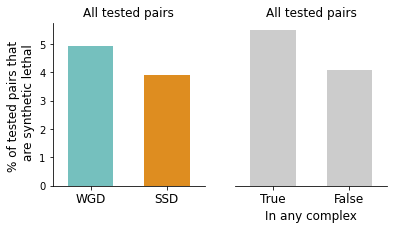

In [15]:
## Plot 
f, axes = plt.subplots(1, 2, figsize=(6,3), gridspec_kw={'width_ratios': [1,1]}, sharey = True)

## WGD
ax = sns.barplot(x = 'WGD_or_SSD', y = '% of tested pairs that are synthetic lethal', data = WGD_SSD_tab, ax = axes[0], width = 0.6, 
                 palette=['#68CCCA', '#FE9200'])
# Figure format
# Hide X axis label
ax.set_xlabel('')
# Set x axis tick labels
ax.set_xticklabels(['WGD', 'SSD'], fontsize=12)
# Set y axes labels
ax.set_ylabel('% of tested pairs that \n are synthetic lethal', fontsize=12)
# Spine of the plot 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set the subplot title
ax.set_title('All tested pairs', fontsize = 12)


## either in complex 
ax2 = sns.barplot(x = 'either_in_complex', y = '% of tested pairs that are synthetic lethal', data = complex_tab, ax = axes[1], width = 0.6, 
                  palette=['#CCCCCC', '#CCCCCC'])
# Figure format
# Set x axis labels
ax2.set_xlabel('In any complex', fontsize=12)
# Set x axis tick labels
ax2.set_xticklabels(['True', 'False'], fontsize=12)
# Hide y axis label and ticks
ax2.get_yaxis().set_visible(False)
# Spine of the plot 
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
# Set the subplot title
ax2.set_title('All tested pairs', fontsize=12)

# Save the plot 
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/07_analysis_of_the_hits/barplot_WGD_SSD_proteinComplexMembership.pdf', dpi=400, bbox_inches='tight')

2. Min. sequence identity

In [16]:
# statistical testing to test if there is significant difference in sequence identity between the SLs and non-SLs pairs in all tested pairs
print('SLs vs non-SLs Mann-U (All tested pairs)', 'stat=%.1f, pval=%e' % stats.mannwhitneyu(cand_pair[cand_pair.SL == True].min_sequence_identity, cand_pair[cand_pair.SL == False].min_sequence_identity, alternative='two-sided'))
results_mannU_ALL = stats.mannwhitneyu(cand_pair[cand_pair.SL == True].min_sequence_identity, cand_pair[cand_pair.SL == False].min_sequence_identity, alternative='two-sided')

SLs vs non-SLs Mann-U (All tested pairs) stat=3800.5, pval=1.826107e-03


In [17]:
# statistical testing to test if there is significant difference in sequence identity between the SLs and non-SLs pairs only in WGD
print('SLs vs non-SLs Mann-U (WGD)', 'stat=%.1f, pval=%e' % stats.mannwhitneyu(cand_pair[(cand_pair.SL == True) & (cand_pair.WGD == True)].min_sequence_identity, cand_pair[(cand_pair.SL == False) & (cand_pair.WGD == True)].min_sequence_identity, alternative='two-sided'))
results_mannU_WGD = stats.mannwhitneyu(cand_pair[(cand_pair.SL == True) & (cand_pair.WGD == True)].min_sequence_identity, cand_pair[(cand_pair.SL == False) & (cand_pair.WGD == True)].min_sequence_identity, alternative='two-sided')

SLs vs non-SLs Mann-U (WGD) stat=2243.5, pval=2.272592e-02


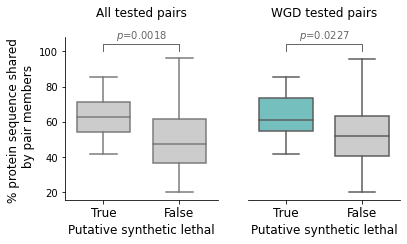

In [18]:
# plot 
f, axes = plt.subplots(1, 2, figsize=(6,3), gridspec_kw={'width_ratios': [1,1]}, sharey = True)
plot_df = pd.DataFrame(cand_pair)
plot_df.loc[:,'min_sequence_identity'] *= 100 # Get the percentage of sequence identity


# All tested pairs 
ax = sns.boxplot(x = "SL", y = "min_sequence_identity", palette = ['#CCCCCC', '#CCCCCC'], data = plot_df, 
                 whis = [0,100], ax = axes[0], width = 0.7, order = [True, False])


# Signficance bar
txt = '$p$=%.4f' % results_mannU_ALL[1] 
ax.plot([0, 0, 1, 1], [100, 104, 104, 100], lw=1, c='#666')
ax.text(0.5, 105, txt, ha='center', va='bottom', color='#666', fontsize=10)


## Figure format
# Set x axis labels
ax.set_xlabel('Putative synthetic lethal', fontsize=12); ax.set_ylabel('% protein sequence shared \n by pair members', fontsize = 12)
# Set x axis ticks
ax.set_xticklabels(['True', 'False'], fontsize = 12)
# Spine of the plot 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('All tested pairs', fontsize=12, pad = 20)


# Only WGD pairs
plot_df = plot_df[plot_df.WGD == True]
ax2 = sns.boxplot(x='SL', y='min_sequence_identity', palette=['#68CCCA', '#CCCCCC'], data = plot_df, 
                  whis=[0,100], ax = axes[1], width = 0.7, order = [True, False])

# Signficance bar
txt2 = '$p$=%.4f' % results_mannU_WGD[1] 
ax2.plot([0, 0, 1, 1], [100, 104, 104, 100], lw=1, c='#666')
ax2.text(0.5, 105, txt2, ha='center', va='bottom', color='#666', fontsize=10)

## Figure format 
# Set x axis labels
ax2.set_xlabel('Putative synthetic lethal', fontsize=12)
# Set x axis tick labels
ax2.set_xticklabels(['True', 'False'], fontsize=12)
# Hide y axis label and ticks
ax2.get_yaxis().set_visible(False)
# Spine of the plot 
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
# Set the subplot title
ax2.set_title('WGD tested pairs', fontsize=12, pad = 20)

# Save the plot 
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/07_analysis_of_the_hits/boxplot_proteinSeqIdentity.pdf', dpi = 400, bbox_inches = 'tight')

3. Prediction score of SLs

In [19]:
# statistical testing to test if there is significant difference in sequence identity between the SLs and non-SLs pairs in all tested pairs
print('SLs v non-SLs Mann-U (All tested pairs)', 'stat=%.1f, pval=%e' % stats.mannwhitneyu(cand_pair[cand_pair.SL == True].prediction_score, cand_pair[cand_pair.SL == False].prediction_score, alternative='two-sided'))
results_mannU_ALL_pred_score = stats.mannwhitneyu(cand_pair[cand_pair.SL == True].prediction_score, cand_pair[cand_pair.SL == False].prediction_score, alternative='two-sided')

SLs v non-SLs Mann-U (All tested pairs) stat=4188.0, pval=3.727949e-05


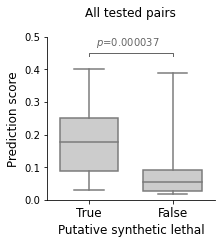

In [20]:
# plot 
f, ax = plt.subplots(1, 1, figsize=(3,3))
plot_df = pd.DataFrame(cand_pair)

# All tested pairs 
ax = sns.boxplot(x = "SL", y = "prediction_score", palette = ['#CCCCCC', '#CCCCCC'], data = plot_df, 
                 whis = [0,100], ax = ax, width = 0.7, order = [True, False])


# Signficance bar
txt = '$p$=%.6f' % results_mannU_ALL_pred_score[1] 
ax.plot([0, 0, 1, 1], [0.44, 0.45, 0.45, 0.44], lw=1, c='#666')
ax.text(0.46, 0.46, txt, ha='center', va='bottom', color='#666', fontsize=10)


## Figure format
ax.set_ylim([0,0.5])
# Set x axis labels
ax.set_xlabel('Putative synthetic lethal', fontsize=12); ax.set_ylabel('Prediction score', fontsize = 12)
# Set x axis ticks
ax.set_xticklabels(['True', 'False'], fontsize = 12)
# Spine of the plot 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('All tested pairs', fontsize=12, pad = 20)



# Save the plot 
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/07_analysis_of_the_hits/boxplot_predictionScore.pdf', dpi = 400, bbox_inches = 'tight')